In [5]:
import numpy as np
import pandas as pd
import os, gensim
from nltk.tokenize import word_tokenize
import fasttext
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder 
from umap import UMAP
from pathlib import Path
from copy import deepcopy
from importlib import reload
from pathlib import Path
from matplotlib import pyplot as plt
from claims_topics.utils import utils
from claims_topics.resources import preprocessor as preproc
from claims_topics.services import file
from claims_topics.config import global_config as glob
from claims_topics.config import config

pd.set_option('display.max_colwidth', 30)
pd.set_option('display.max_rows', 500)
 
reload(glob)
reload(utils)
reload(file)
reload(config)
reload(preproc)

[nltk_data] Downloading package punkt to /home/alexv84/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/alexv84/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


<module 'claims_topics.resources.preprocessor' from '/home/alexv84/Documents/GitHub/invoice_topics/src/claims_topics/resources/preprocessor.py'>

## Read in data:

In [6]:
config_input = config.io['input']

df = file.CSVService(root_path=glob.UC_DATA_DIR, schema_map=config_input['schema_map']['text_cols'], **config_input['service']['CSVService']).doRead()

print(df.shape)

(405350, 42)


In [8]:
# Columns to use:
#-----------------
#col_sel = ['id_sch','invoice_item_id', 'dl_gewerk','firma', 'yylobbez', 'erartbez', 'hsp_eigen', 'hsp_prodbez', 'sartbez', 'sursbez', 'schilderung', 'de1_eks_postext']
#col_sel = ['dl_gewerk','de1_eks_postext']
col_sel = ['assigned_labels', 'invoice_text', 'clm_descr']
#col_sel = ['de1_eks_postext']

corpus = df[col_sel].drop_duplicates(subset=col_sel, keep=False) #.head(1*10**3)

print(corpus.shape)
corpus.head(10)

(365443, 3)


,assigned_labels,invoice_text,clm_descr
0,Sonstiges,Femacellplatten 20 mm einb...,LW Schaden\r\nLeck nicht g...
1,Installationsarbeiten,Siliconfuge entlang dem So...,LW Schaden\r\nLeck nicht g...
3,Trocknung,Arbeitsstunden Bock 07 .06...,LW; fehlende Schraube am D...
4,Eternit-/Skobalit-Dach,Dachfläche mit polycarbona...,Hagelschaden an den Jalous...
5,Fliesenarbeiten,Haftgrundlerung Bodenfläch...,Rohrverschraubung undicht
6,Sonstiges,"Kunststoffsockel, RAL 7016...",Durch den Sturm und Hagel ...
7,Sonstiges,Blindnietmutter M8 352.324,Durch den Sturm und Hagel ...
8,Eternit-/Skobalit-Dach,Alu Band PP 50 mm 50 m Typ...,Carport (freistehend) durc...
9,Eternit-/Skobalit-Dach,Mendinger Mittelprofil pre...,Carport (freistehend) durc...
10,Fliesenarbeiten,Wannenablage Wanneli*!ase...,bitte mit dem VN sprechen ...


### Preprocess data, encode labels, prepare input for word2vec format... 

In [80]:
# Create labels for supervised topic modeling:
target = LabelEncoder().fit_transform(corpus['assigned_labels'].tolist())   # labels

# Build corpus
X = corpus['invoice_text']
#X = corpus['clm_descr']
#corpus['target'] = target

# Preprocess corpus:
cleaner = preproc.clean_text(language='german', without_stopwords=['nicht', 'keine'], lemma = False, stem = True)

X_cl = cleaner.fit_transform(X)

docs = X_cl.tolist()                            # format for BertTopic
target_names = corpus['assigned_labels'].tolist()       # class labels

corpus_cl = X_cl.apply(lambda x: word_tokenize(x))       # this format needed for word2vec training only

sentences = corpus_cl.tolist() 

Using 232 stop words.
Added 20 stopword(s).
Adding custom German stop words...
Removed 2 stopword(s).
Loading nltk stemmer.
Setting to lower cases.
Removing whitespaces.
Applying word tokenizer.
Removing custom stopwords.
Removing punctuations.
Removing numbers.
Removing digits.
Removing non-alphabetic characters.
Replacing German Umlaute.
Removing special character punctuations.
Removing short tokens.
Applying stemming.
Finished preprocessing!


Prepare training data for fasttext: 

In [81]:
config_output = config.io['output']
Path(glob.UC_DATA_PKG_DIR).mkdir(parents=True, exist_ok=True)

file.TXTService(verbose=True, root_path=glob.UC_DATA_PKG_DIR, **config_output['service']['TXTService']).doWrite(docs)

TXT Service output to file: /home/alexv84/Documents/GitHub/invoice_topics/src/claims_topics/data/train_data_fasttext.txt


# FastText

In [82]:
# Train model
#-------------
reload(utils)

mtype = 'skipgram'    #'cbow'  

print(f"-- Using {'Skip-gram' if mtype == 'skipgram' else 'CBOW'} --")
# Training word embeddings: 
model = fasttext.train_unsupervised(os.path.join(glob.UC_DATA_PKG_DIR,'train_data_fasttext.txt'), wordNgrams = 2, dim=100, epoch=60, lr=0.05, model=mtype, verbose=2)
print("Done!")

-- Using Skip-gram --


Read 1M words
Number of words:  18168
Number of labels: 0
Progress: 100.0% words/sec/thread:   48427 lr:  0.000000 avg.loss:  1.035894 ETA:   0h 0m 0s

Done!


In [83]:
#model.words
#model.get_word_vector("haftkleber")
model.get_nearest_neighbors('haftkleber')

[(0.7948389649391174, 'haftkleb'),
 (0.6829271912574768, 'kleber'),
 (0.6581794023513794, 'altkleb'),
 (0.6321030259132385, 'kaltkleb'),
 (0.6146448850631714, 'kraftkleb'),
 (0.5647808313369751, 'kaltklebebahn'),
 (0.5613037347793579, 'eber'),
 (0.5603737235069275, 'restkleb'),
 (0.5569964051246643, 'haftemulsion'),
 (0.5547472238540649, 'nichtkleb')]

Save model:

In [45]:
# Save the trained model
model.save_model(os.path.join(glob.UC_DATA_DIR,'fasttext_trained_model.bin'))
print("Model saved.")

Load model:

In [85]:
# Load pre-trained model
#model = fasttext.load_model(os.path.join(glob.UC_DATA_DIR,'fasttext_trained_model.bin'))

### Create document (= sentence) embeddings from word embeddings

In [84]:
reload(utils)

embeddings, index2doc, doc2index = utils.get_fasttext_document_embeddings(model, docs)         

print(embeddings.shape)
print(len(docs))

100%|██████████| 365443/365443 [00:09<00:00, 36837.78it/s]


(365443, 200)
365443


Instantiate HDBSCAN:

In [49]:
from hdbscan import HDBSCAN

cluster_model = HDBSCAN(min_cluster_size=15, cluster_selection_method='eom', prediction_data=True)

# from sklearn.cluster import KMeans, Birch

# cluster_model = KMeans(n_clusters=50)

## Build topic model based on trained document embeddings:

Semi-supervised

In [50]:
new_labels = target.copy()
ind = np.array(target_names) == 'Sonstiges'   # keep out this category (unsupervised set of observations!)
new_labels[ind] = -1           # ignore
new_labels = new_labels.tolist()

Use transfer learning:

In [107]:
# from sentence_transformers import SentenceTransformer

# nr_topics = 10
# sentence_model = SentenceTransformer("deepset/gbert-base", device="cuda")

# topic_model = BERTopic(verbose=True, language="german", embedding_model=sentence_model,    
#                        vectorizer_model = vectorizer, nr_topics=nr_topics,
#                        diversity=None)

#?BERTopic

Use own embeddings:

In [51]:
from bertopic import BERTopic

os.environ["TOKENIZERS_PARALLELISM"] = "false"

nr_topics = 6     # number of clusters
#nr_topics = "auto"

topic_model = BERTopic(verbose=True, nr_topics=nr_topics, hdbscan_model=cluster_model, umap_model=None, diversity = 0.5)   # Maximal Marginal Relevance -> diversity = 0 / Not diverse
#topics, _ = topic_model.fit_transform(docs, embeddings = embeddings)                  # unsupervised  
#topics, _ = topic_model.fit_transform(docs, embeddings = embeddings, y=target)         # supervised
topics, _ = topic_model.fit_transform(docs, embeddings = embeddings, y=new_labels)         # semi-supervised

2022-11-19 19:27:59,488 - BERTopic - Reduced dimensionality
2022-11-19 19:28:07,937 - BERTopic - Clustered reduced embeddings
2022-11-19 19:28:13,305 - BERTopic - Reduced number of topics from 50 to 6


In [52]:
topic_model.get_topic_info()

,Topic,Count,Name
0,0,86452,0_entfernen_wand_entsorgen...
1,1,59998,1_entsorgung_monteur_demon...
2,2,47777,2_liefern_montieren_verleg...
3,3,47011,3_rotguss_bogen_grad_sanpress
4,4,36231,4_weiss_montage_verchromt_...
5,5,28851,5_baustelleneinrichtung_ab...


In [53]:
df_new = pd.DataFrame({'Text': docs})
df_new['Cluster'] = topics
df_new

,Text,Cluster
0,femacellplatten einbauen,2
1,siliconfuge entlang sockel,0
2,arbeitsstunden bock,1
3,dachflaeche polycarbonat t...,2
4,haftgrundlerung bodenflaec...,0
...,...,...
306315,geberit silent abzweig grad,3
306316,raum wandtrocknungen stand...,0
306317,wasserschaden betroffenen ...,0
306318,geruestkosten einruesten w...,5


In [32]:
#topic_model.save(os.path.join(glob.UC_DATA_ROOT,"invoice_topic_model"))     # save
#topic_model = BERTopic.load(os.path.join(glob.UC_DATA_ROOT,"invoice_topic_model"))   # load

In [33]:
# Merge cluster assignments to orginal corpus:
#corpus['topic'] = topics
#corpus.merge(topic_model.get_topic_info()[['Topic', 'Name']], how="left", left_on='topic', right_on='Topic')

In [34]:
#topic_model.get_topic_info().head(10)

Create more intuitive topic labels:

In [54]:
topic_labels = topic_model.generate_topic_labels(nr_words=3,
                                                 topic_prefix=False,
                                                 word_length=10,
                                                 separator=", ")
#topic_labels

In [55]:
topic_model.set_topic_labels(topic_labels)

In [56]:
#topic_model.visualize_topics()
#topic_model.get_topic(0)
#topic_model.visualize_hierarchy(top_n_topics=50)
#topic_model.visualize_heatmap(n_clusters=nr_topics-1, width=1000, height=1000)

In [57]:
# Reduce dimensionality of embeddings, this step is optional but much faster to perform iteratively:
#reduced_embeddings = UMAP(n_neighbors=5, n_components=2, min_dist=0.0, metric='cosine').fit_transform(embeddings)

#fig = topic_model.visualize_documents(docs, reduced_embeddings=reduced_embeddings)

#fig.write_html(os.path.join(glob.UC_DATA_ROOT, "doc_chart.html"))    # save as html

In [58]:
fig = topic_model.visualize_barchart(n_words=10, top_n_topics=nr_topics , width=400, height=350)    # plotly figure object
fig

In [59]:
fig.write_html(os.path.join(glob.UC_DATA_PKG_DIR, "topic_barchart2.html"))    # save as html

In [36]:
#np.any(np.isnan(doc_vectors))
#np.all(np.isfinite(doc_vectors))

### Train UMAP for document embedding visualization:

In [85]:
embedding_umap = UMAP(n_components=2).fit(embeddings)

umap_embeddings = embedding_umap.embedding_

In [ ]:
umap_embeddings.shape

(306320, 2)

Visualize compressed document embeddings in 2D

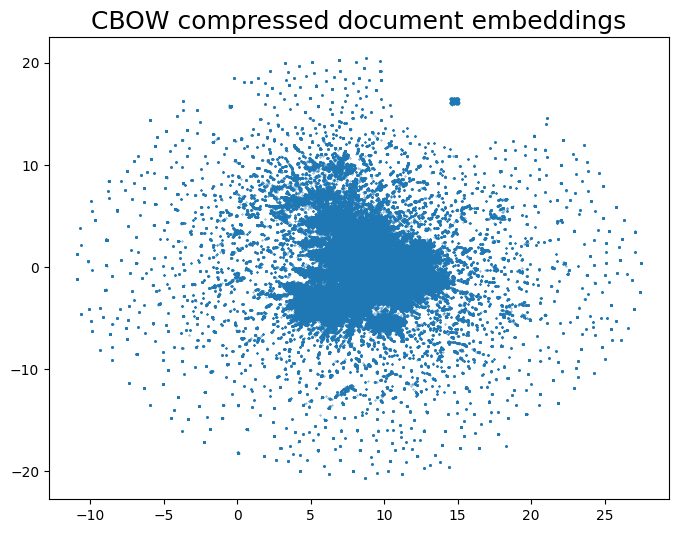

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8, 6))
plt.scatter(
    umap_embeddings[:, 0], umap_embeddings[:, 1], cmap="Spectral", s=0.1
)
plt.title("CBOW compressed document embeddings", fontsize=18)

plt.show();

In [1]:
#X = embeddings.copy()
#X = embeddings[:10**3,:]  # for test

## Graph analytics:

In [128]:
import umap
from sklearn.preprocessing import StandardScaler

embeddings_sc = StandardScaler().fit_transform(embeddings)

embedding_umap = umap.UMAP(n_components=15).fit(embeddings_sc)

X = embedding_umap.embedding_

print(X.shape)

(365443, 15)


In [131]:
reload(utils)

dist, L2_thresh = utils.adjstruct_generator.create(embeddings = X, corpus = X_cl, doc2index = doc2index, dist_thresh = 0.2, metric = "angular")   # metric = "angular"
print(L2_thresh)

** Using angular metric for approx. 5-NN **


100%|██████████| 365443/365443 [00:00<00:00, 1264826.75it/s]


- Indexing finished and saved as: /home/alexv84/Documents/GitHub/invoice_topics/src/claims_topics/data/knn_index.ann


100%|██████████| 365443/365443 [00:20<00:00, 18261.64it/s]

- Adjacency list created and saved as: /home/alexv84/Documents/GitHub/invoice_topics/src/claims_topics/data/graph_adjlist.txt
Done.
0.2


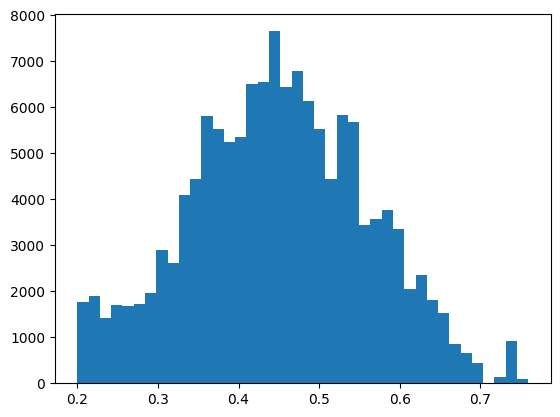

In [132]:
plt.hist(dist, bins=40);

Create undirected weighted graph based on document embeddings:

In [133]:
import networkx as nx

G = nx.read_weighted_edgelist(os.path.join(glob.UC_DATA_PKG_DIR,'graph_adjlist.txt'))     # with

# G_df = pd.read_csv(os.path.join(glob.UC_DATA_PKG_DIR, 'graph_adjlist.txt'), delim_whitespace=True, 
#                    header=None, names=['n1', 'n2', 'weight']) #.sort_index()      # Ex.: groupby-count structure
# G_df

In [100]:
#G.edges(data=True)

In [101]:
# pos = nx.spring_layout(G)
# nx.draw(G, pos, node_size = 75, alpha = 0.8)
# plt.show()

Add node betweenness centrality as node attribute

In [ ]:
bb = nx.betweenness_centrality(G)

nx.set_node_attributes(G, bb, "betweenness")   

In [ ]:
#G.nodes(data=True)

Create the induced subgraph of each connected component:

In [134]:
S = [G.subgraph(c).copy() for c in nx.connected_components(G)]

In [128]:
from community import community_louvain

comms = community_louvain.best_partition(G)   #keys of the dictionary are the nodes and the values correspond to the community which that node belongs to

In [129]:
unique_coms = np.unique(list(comms.values()))
unique_coms

array([   0,    1,    2, ..., 2579, 2580, 2581])

Collect members per community:

In [130]:
com_dict = {}
for com in comms.values():
  members = set()
  for ns in comms.keys():
    if comms[str(ns)] == com:
      members.add(ns)
      com_dict[str(com)] = members

KeyboardInterrupt: 

In [ ]:
len(com_dict)

In [103]:
S = [G.subgraph(c).copy() for c in com_dict.values()]
#S = [G.subgraph(c).copy() for c in nx.connected_components(G)]
len(S)

NameError: name 'com_dict' is not defined

In [135]:
sub_G = iter(S)     # iterate over subgraphs

In [152]:
sub_i = next(sub_G)

print(len(sub_i.nodes()))

164


In [153]:
pg_rank = nx.pagerank(G = sub_i)

max_rank_index = max(pg_rank, key=pg_rank.get)

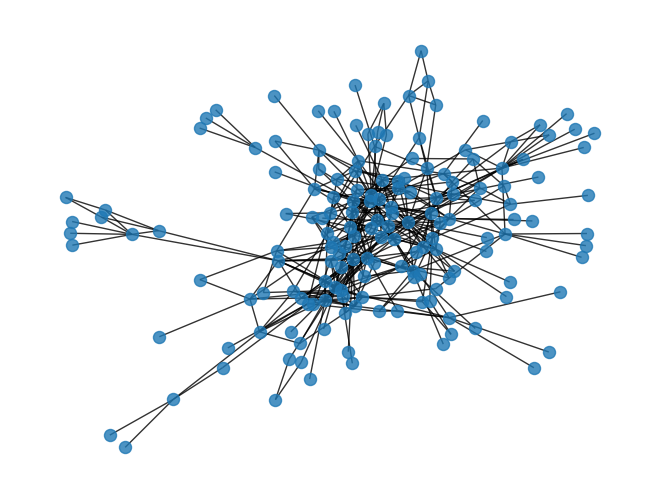

In [154]:
#nx.draw_networkx(sub_i)

pos = nx.spring_layout(sub_i)
nx.draw(sub_i, pos, node_size = 75, alpha = 0.8)
plt.show()

In [155]:
#G.edges(data=True)

#sub_i.nodes(data=True)

In [156]:
for no in sub_i.nodes():
  print(no)
  print(index2doc[int(no)])

49841
xtra uebergang
271432
pistolenschaum
39927
filzdaemmband
185436
silent muff
162992
klein verbrauchsmaterial
49825
badewann
40407
conel flex schlauchisolier ungeschl laeng
331413
schnellbindemoertel
282792
crassus verbind
307726
dito ubergangsmuff
30217
schiebemuff sanpress profipress rotguss pressanschluss
77547
viega fertigset multiplex visign verchromt
90741
kupferrohr dvgw halbhart stang
357583
uponor nippel
62969
apid verbind
227111
wannenank mepa wannenrandabstuetz
262633
dicht kleinmaterial
163654
schutzschlauch flex plus conel schutzfoll gleitfoll
8457
trinkwasserrohr roll
83964
schlossschraub
216087
alufix verschlussklebeband
344346
crassus hlauchadapt
229282
grossentlueft
230218
silent muff geberit
66612
isolierlack
104873
ventilator
280433
conlit schal
84121
punis schiauchadapt
249467
dicht kleinmaterial
359070
xtrafiex schlauchisolier
324988
materialkost rohrebis durchmess
259243
armalok isolier
331418
bauschutt
153231
uebergangsstueck sanpress profipress rotguss press

In [ ]:

# scores_doc = deepcopy(corpus_cl)
# scores_doc.shape
# scores_doc['page rank'] = list(scores.values())

# ranked_sentence = scores_doc.sort_values(by='page rank', ascending=False, na_position='first')

# top_n = 3
# summarize_text = ranked_sentence.head(top_n)

# print("Top ranked_sentences:\n")
# for z, i in enumerate(summarize_text['text'].values):
#     print(z, i, "\n")

In [157]:
index2doc[int(max_rank_index)]

'abzweig muff abgang'

In [141]:
index2doc.keys()
index2doc[int(no)]

'einsatz bohrhamm hilti'

## Convert networkX graph to pyG

In [111]:
#from torch_geometric.utils.convert import from_networkx

import torch, os
import torch.nn as nn
import torch.nn.functional as F

In [113]:
from torch_geometric.nn.models import InnerProductDecoder, VGAE
#from torch_geometric.nn.conv import GCNConv
#from torch_geometric.utils import negative_sampling, remove_self_loops, add_self_loops


OSError: /home/alexv84/anaconda3/envs/invoice_clustering/lib/python3.10/site-packages/torch_sparse/_version_cuda.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKSs